In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np 

from utils.visualization.visualize import plot_decision_boundary
from utils.data.helpers import list_to_model, model_to_list, rotate, get_moons_dataset
from utils.model.models import MLP

import torch
import torch.nn.utils.prune as prune

from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
def get_accuracy(model, X, y):
    y_pred = model(torch.tensor(X).float()).squeeze().round().detach().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

In [8]:
from matplotlib.patches import Patch

def get_importance_map(dataset):
    X, y = get_moons_dataset(n_samples=1000, noise=0.1)
    importance = np.zeros((151))
    less_than_80 = 0
    for i in tqdm(range(len(dataset))):
        model_index = i

        model = MLP(2, [10, 10], 1, use_batch_norm=False)
        weights = dataset.iloc[model_index, 1:-1].values.tolist()
        angle = dataset.iloc[model_index, -1]
        list_to_model(model, weights)

        module_1 = model.fc1[0]
        module_2 = model.hidden_layers[0][0]
        module_3 = model.fc2
        prune.l1_unstructured(module_1, name="weight", amount=0.25)
        prune.l1_unstructured(module_1, name="bias", amount=0.0)
        prune.l1_unstructured(module_2, name="weight", amount=0.5)
        prune.l1_unstructured(module_2, name="bias", amount=0.5)
        prune.l1_unstructured(module_3, name="weight", amount=0.25)
        prune.l1_unstructured(module_3, name="bias", amount=0.5)

        X_rotated = rotate(X, angle)
        accuracy = get_accuracy(model, X_rotated, y)
        if(accuracy < 80):
            less_than_80 += 1

        mask = np.array([])
        mask = np.append(mask, module_1.weight_mask.flatten().numpy())
        mask = np.append(mask, module_1.bias_mask.flatten().numpy())
        mask = np.append(mask, module_2.weight_mask.flatten().numpy())
        mask = np.append(mask, module_2.bias_mask.flatten().numpy())
        mask = np.append(mask, module_3.weight_mask.flatten().numpy())
        mask = np.append(mask, module_3.bias_mask.flatten().numpy())
        importance += mask
    
    return importance, less_than_80

def plot_imporance(importance, title="Parameters presense after pruning", size=(15,5)):
    f, ax = plt.subplots(figsize=size)
    handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]
    color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]
    ax.bar(range(len(importance)), importance, color=color)
    ax.set_xlabel('Parameter index')
    ax.set_ylabel('# of models using this parameter after pruning')
    ax.set_title(title)
    ax.legend(handles=handles)
    return ax

In [67]:
dataset = pd.read_csv('../data/eight_angles.csv')
dataset.head()

importance, less_than_80 = get_importance_map(dataset)
print(less_than_80)
print(importance)

100%|██████████| 80000/80000 [03:02<00:00, 439.10it/s]

196
[59953. 60013. 59878. 60054. 60150. 60248. 60059. 59918. 59861. 59948.
 60070. 60143. 59947. 59789. 60026. 60077. 60033. 60002. 59866. 59965.
 80000. 80000. 80000. 80000. 80000. 80000. 80000. 80000. 80000. 80000.
 40195. 39527. 40268. 39933. 39750. 39934. 39697. 39923. 40067. 39920.
 39974. 40186. 40016. 40145. 39931. 40176. 39817. 39858. 39940. 39800.
 39976. 40227. 40059. 39924. 39843. 39904. 39902. 39917. 40466. 39966.
 39976. 39989. 40339. 39882. 40155. 39961. 39890. 40018. 40178. 39838.
 39935. 39913. 40235. 40141. 39906. 40041. 39911. 40033. 40056. 39963.
 40058. 39822. 40226. 39981. 40047. 40187. 39762. 39909. 40100. 40222.
 40010. 40246. 40059. 40159. 39871. 40101. 40069. 40034. 40087. 39973.
 39923. 39876. 40216. 40148. 40031. 39955. 40015. 39849. 40078. 40028.
 40040. 39907. 40088. 40091. 39973. 39915. 39878. 40123. 40007. 39750.
 39854. 39930. 40008. 40013. 39981. 40024. 39940. 39955. 40028. 39852.
 39882. 40048. 40219. 39776. 39901. 40009. 39924. 40218. 40244. 39779.
 6

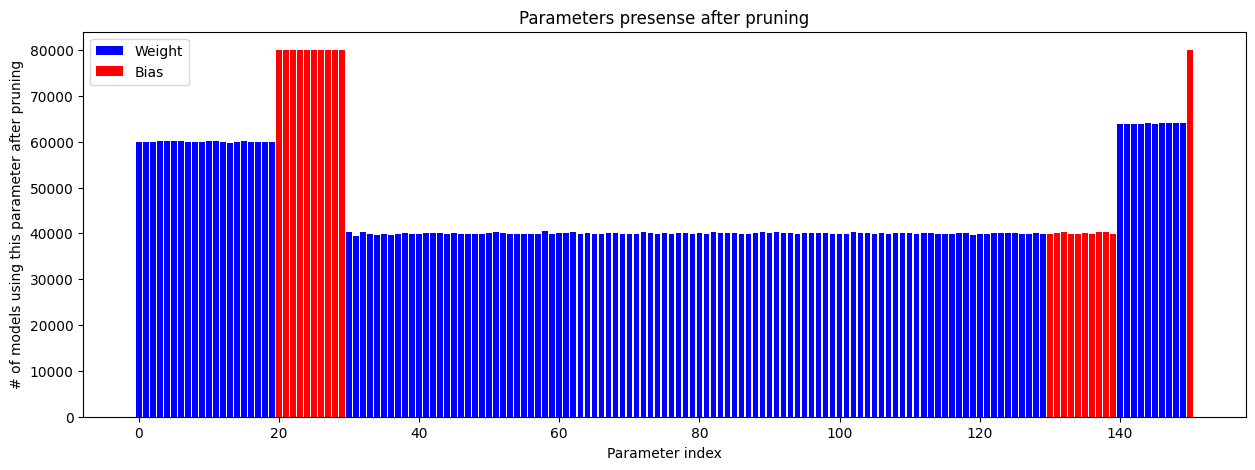

In [68]:
ax = plot_imporance(importance)
plt.show()

100%|██████████| 8/8 [03:12<00:00, 24.06s/it]


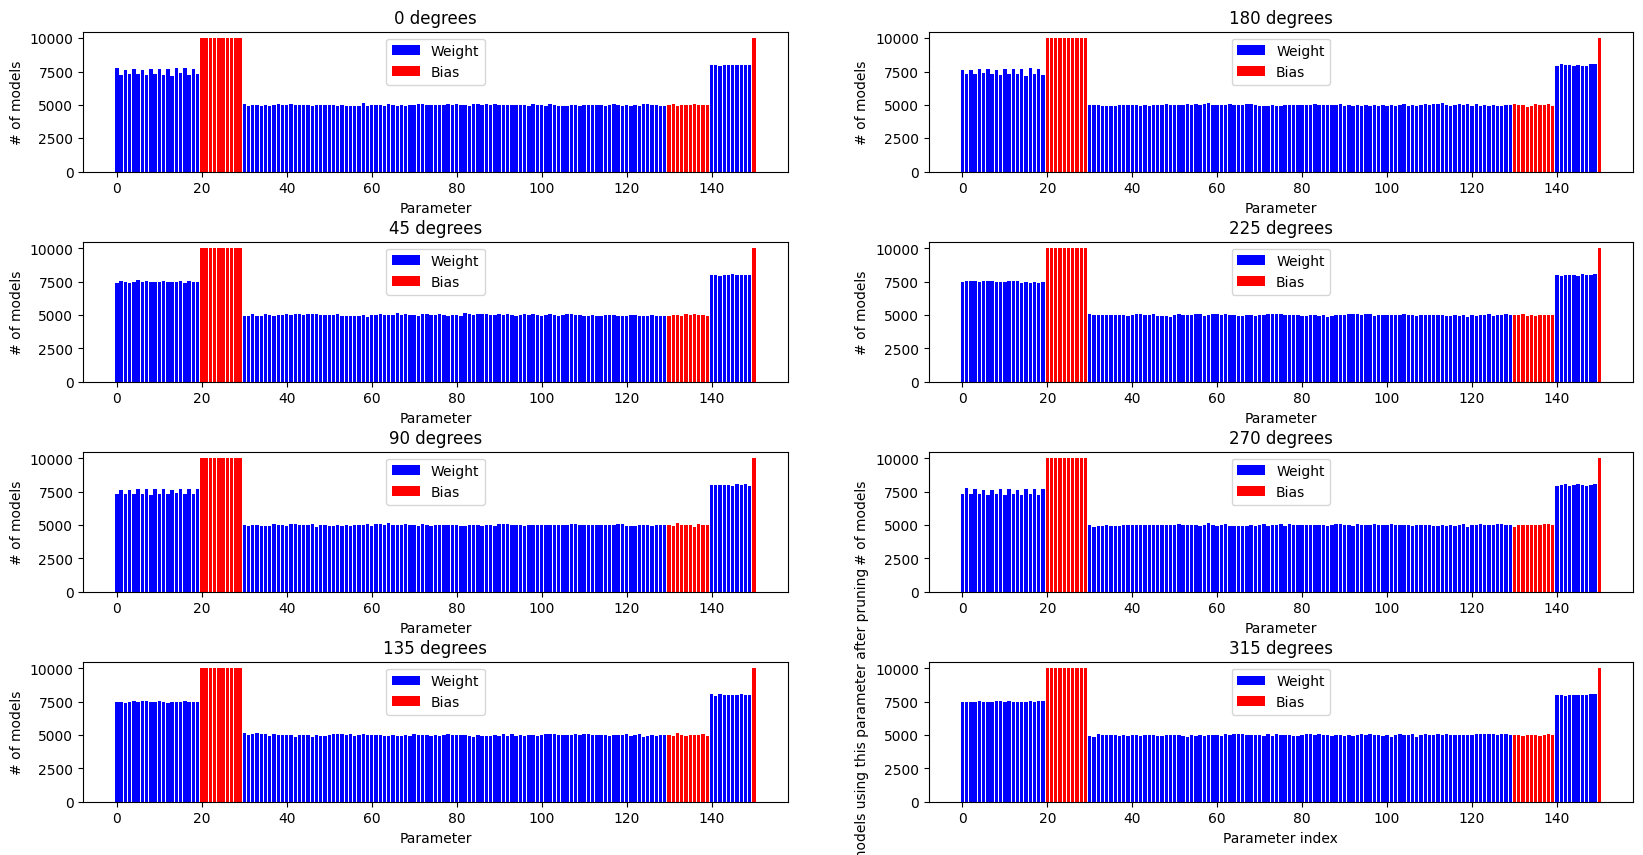

In [66]:
angles = list(range(0,360,45))

handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    dataset_for_angle = dataset[dataset["angle"] == angle]
    importance, less_than_80 = get_importance_map(dataset_for_angle)
    ax[(angle%180)//45][angle//180].bar(range(len(importance)), importance, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle} degrees")
    ax[(angle%180)//45][angle//180].legend(handles=handles)
    ax[(angle%180)//45][angle//180].set_xlabel('Parameter')
    ax[(angle%180)//45][angle//180].set_ylabel('# of models')

plt.xlabel('Parameter index')
plt.ylabel('# of models using this parameter after pruning')
plt.show()

100%|██████████| 10000/10000 [00:19<00:00, 518.49it/s]


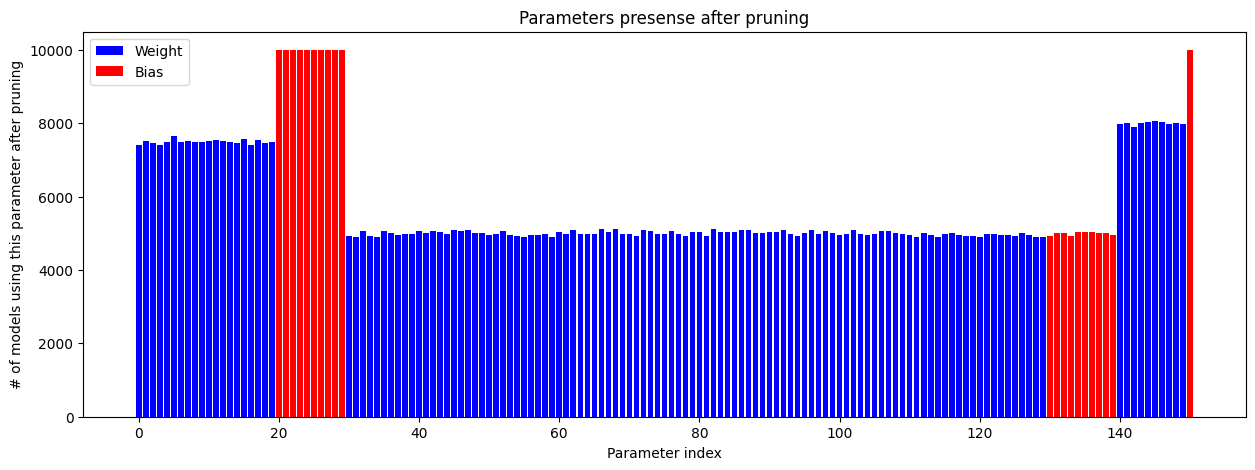

In [11]:
dataset = dataset[dataset["angle"] == 45]
importance, less_than_80 = get_importance_map(dataset)
ax = plot_imporance(importance)
plt.show()

## Projection

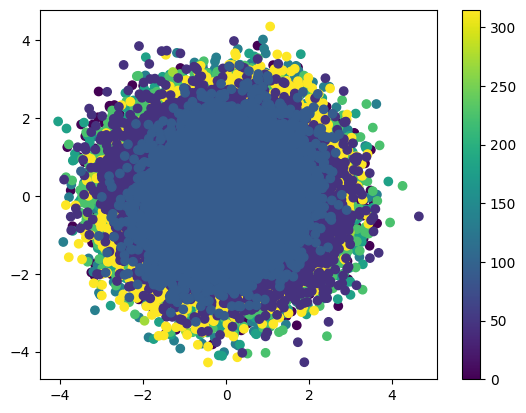

In [12]:
# PCA

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df.drop(columns=["model_name", "angle"])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(weights)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['angle'])
plt.colorbar()
plt.show()

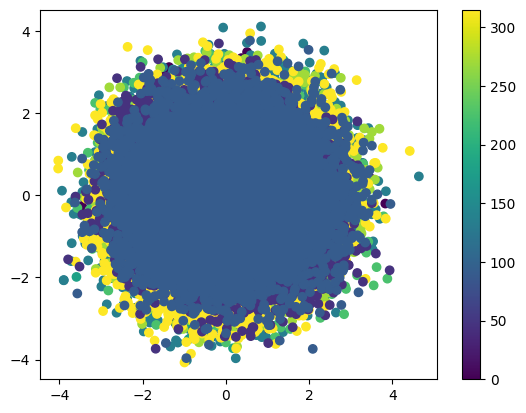

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df[["weight_0", "weight_1", "weight_2", "weight_3", "weight_4", "weight_5", "weight_6", "weight_7", "weight_8", "weight_9", "weight_10", "weight_11", "weight_12", "weight_13", "weight_14", "weight_15", "weight_16", "weight_17", "weight_18", "weight_19", "weight_20", "weight_21", "weight_22", "weight_23", "weight_24", "weight_25", "weight_26", "weight_27", "weight_28", "weight_29", "weight_140", "weight_141", "weight_142", "weight_143", "weight_144", "weight_145", "weight_146", "weight_147", "weight_148", "weight_149", "weight_150"]]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(weights)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['angle'])
plt.colorbar()
plt.show()

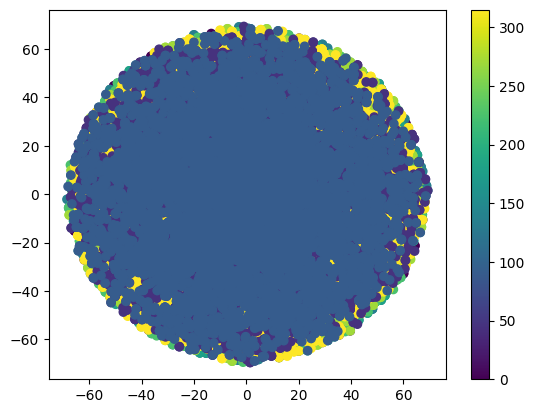

In [13]:
# TSNE

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df.drop(columns=["model_name", "angle"])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(weights)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['angle'])
plt.colorbar()
plt.show()

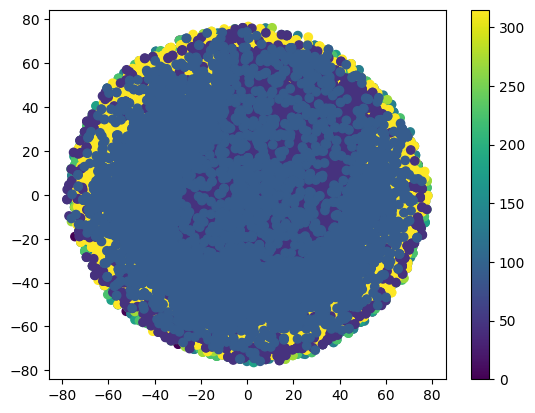

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df[["weight_0", "weight_1", "weight_2", "weight_3", "weight_4", "weight_5", "weight_6", "weight_7", "weight_8", "weight_9", "weight_10", "weight_11", "weight_12", "weight_13", "weight_14", "weight_15", "weight_16", "weight_17", "weight_18", "weight_19", "weight_20", "weight_21", "weight_22", "weight_23", "weight_24", "weight_25", "weight_26", "weight_27", "weight_28", "weight_29", "weight_140", "weight_141", "weight_142", "weight_143", "weight_144", "weight_145", "weight_146", "weight_147", "weight_148", "weight_149", "weight_150"]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(weights)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['angle'])
plt.colorbar()
plt.show()

In [107]:
def get_discard_map(data, angles, X, y):
    model = MLP(2, [8], 1)

    discard_rate = np.zeros((33))
    discard_map = np.ones((33))

    for i in tqdm(range(len(data))):
        weights = data[i]
        X_rotated = rotate(X, angles[i])

        for j in range(1, 33):
            mask = abs(weights).argsort().argsort() < j
            masked_weights = weights.copy()
            masked_weights[mask] = 0
            list_to_model(model, masked_weights)
            accuracy = get_accuracy(model, X_rotated, y)
            if(accuracy < 95):
                break
        mask = abs(weights).argsort().argsort() < j-1
        discard_rate += (discard_map * mask)
    
    return discard_rate

In [96]:
import numpy as np
from utils.model.models import MLP
from utils.data.helpers import get_moons_dataset, list_to_model, rotate
from utils.visualization.visualize import plot_decision_boundary
import torch
from tqdm.notebook import tqdm
from collections import defaultdict

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]


model = MLP(2, [8], 1)

X, y = get_moons_dataset(n_samples=1000, noise=0.1)

In [106]:
discard_rate = np.zeros((33))
discard_map = np.ones((33))
final_maps = []
discarded_counter = defaultdict(int)

for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])

    for j in range(1, 33):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        list_to_model(model, masked_weights)
        accuracy = get_accuracy(model, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)

  0%|          | 0/80000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [98]:
discard_rate = get_discard_map(data, X, y)

  0%|          | 0/80000 [00:00<?, ?it/s]

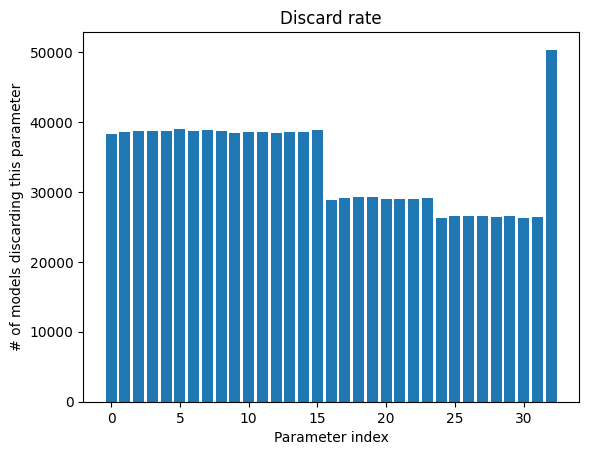

In [99]:
import matplotlib.pyplot as plt

plt.bar(range(33), discard_rate)
plt.title("Discard rate")
plt.xlabel("Parameter index")
plt.ylabel("# of models discarding this parameter")
plt.show()

Text(0, 0.5, 'Number of models')

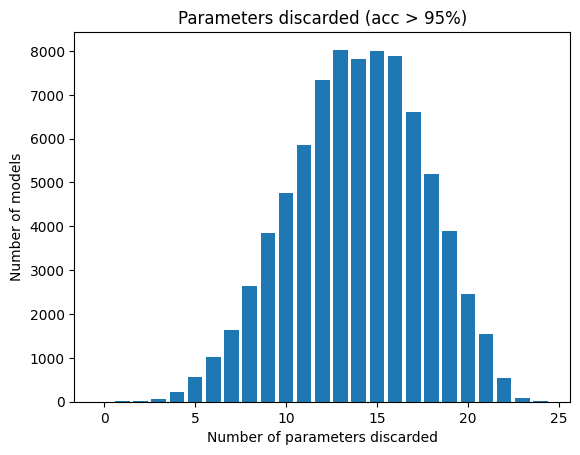

In [100]:
x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("Number of parameters discarded")
plt.ylabel("Number of models")

99.9


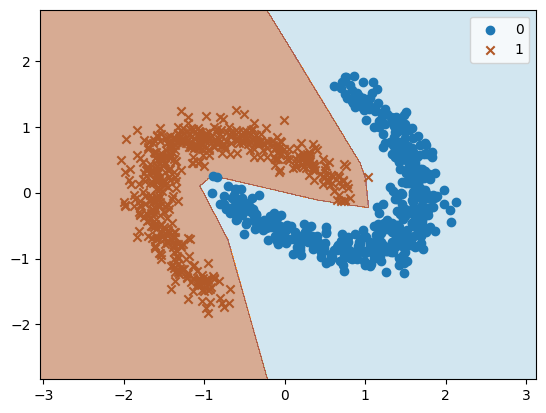

99.9


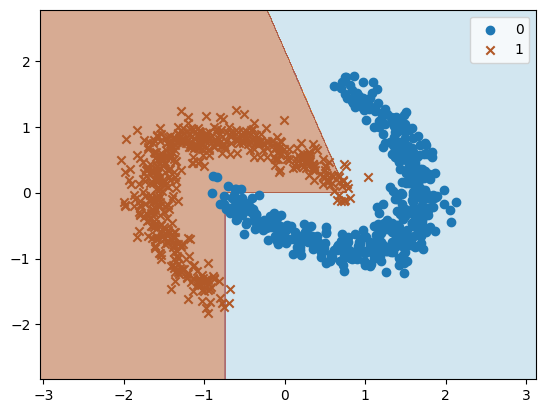

In [81]:
# We can remove 24 parameters and still have 95% accuracy

weights = data[10941]
X_rotated = rotate(X, angles[10941])

mask = abs(weights).argsort().argsort() < 24
masked_weights = weights.copy()
list_to_model(model, masked_weights)
accuracy = get_accuracy(model, X_rotated, y)
print(accuracy)
plot_decision_boundary(model, X_rotated, y)
masked_weights[mask] = 0
list_to_model(model, masked_weights)
print(accuracy)
plot_decision_boundary(model, X_rotated, y)


  0%|          | 0/10000 [00:00<?, ?it/s]

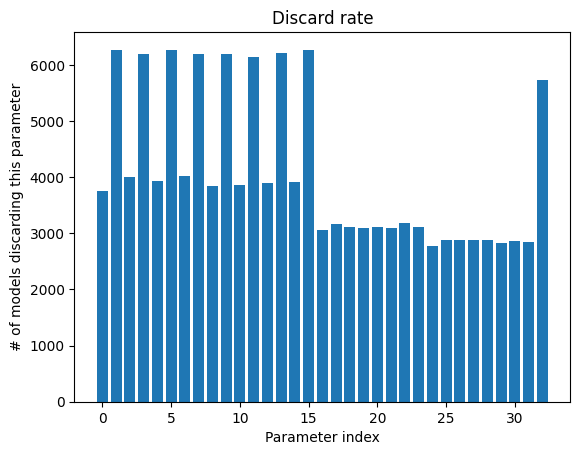

In [104]:
# Only angle 0

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[:10000, -1]
data = data[:10000, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

discard_rate = get_discard_map(data, X, y)

plt.bar(range(33), discard_rate)
plt.title("Discard rate")
plt.xlabel("Parameter index")
plt.ylabel("# of models discarding this parameter")
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

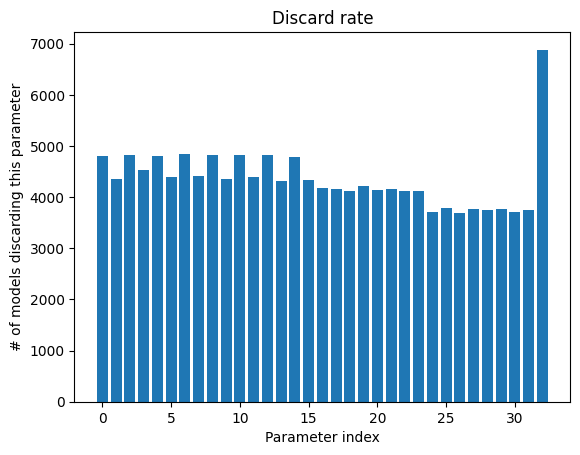

In [108]:
# Only angle 135

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[10000:20000, -1]
data = data[10000:20000, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

discard_rate = get_discard_map(data, angles, X, y)

plt.bar(range(33), discard_rate)
plt.title("Discard rate")
plt.xlabel("Parameter index")
plt.ylabel("# of models discarding this parameter")
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

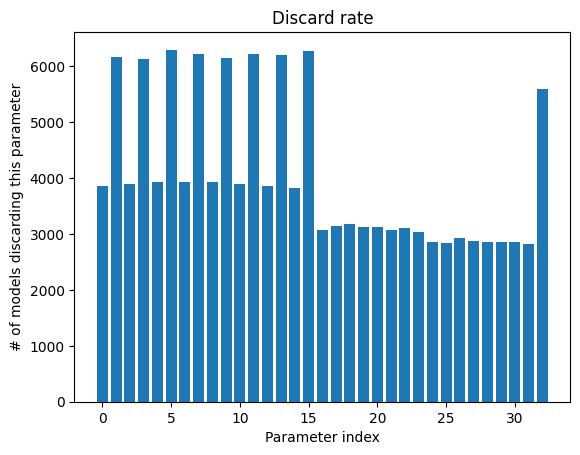

In [109]:
# Only angle 180

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[20000:30000, -1]
data = data[20000:30000, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

discard_rate = get_discard_map(data, angles, X, y)

plt.bar(range(33), discard_rate)
plt.title("Discard rate")
plt.xlabel("Parameter index")
plt.ylabel("# of models discarding this parameter")
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

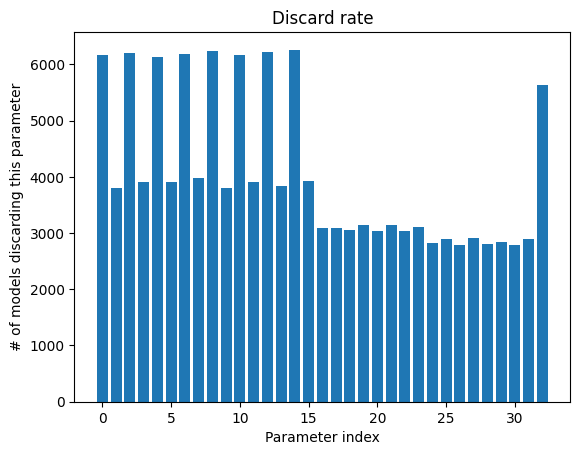

In [110]:
# Only angle 90

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[70000:80000, -1]
data = data[70000:80000, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

discard_rate = get_discard_map(data, angles, X, y)

plt.bar(range(33), discard_rate)
plt.title("Discard rate")
plt.xlabel("Parameter index")
plt.ylabel("# of models discarding this parameter")
plt.show()

## Replace layers

In [16]:
data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

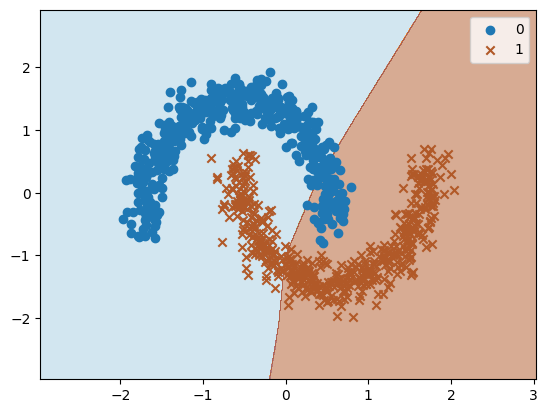

In [54]:
index_1 = 120
index_2 = 20200
weights_1 = data[index_1].copy()
weights_2 = data[index_2].copy()

model = MLP(2, [8], 1)
n = 24
weights_1[16:24] = weights_2[16:24]
list_to_model(model, weights_1)
X_rotated = rotate(X, angles[index_1])
plot_decision_boundary(model, X_rotated, y)

## Projection of the latent space

In [4]:
import torch
import numpy as np

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 10),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 33),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
model.load_state_dict(torch.load("../models/autoencoder_small.pth"))

<All keys matched successfully>

In [5]:
data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

In [6]:
latent_space = model.encoder(torch.tensor(data).float()).detach().numpy()
print(latent_space.shape)

(80000, 10)


In [36]:
print(latent_space[0])

[ 1.0382048   3.2071934  -2.1706786   0.17444575 -8.477653   10.958527
  0.7510251  -1.7632544  -1.402852   -1.7953075 ]


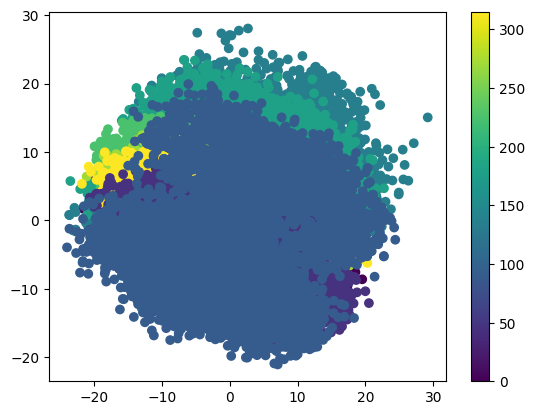

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent_space)
plt.scatter(X_pca[:,0], X_pca[:,1], c=angles)
plt.colorbar()
plt.show()

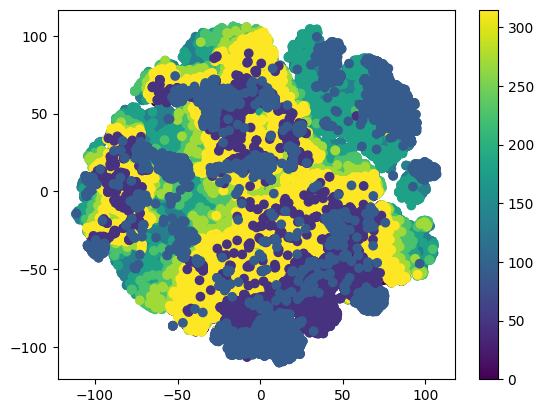

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

pca = TSNE(n_components=2)
X_pca = pca.fit_transform(latent_space)
plt.scatter(X_pca[:,0], X_pca[:,1], cmap="viridis", c=angles)
plt.colorbar()
plt.show()

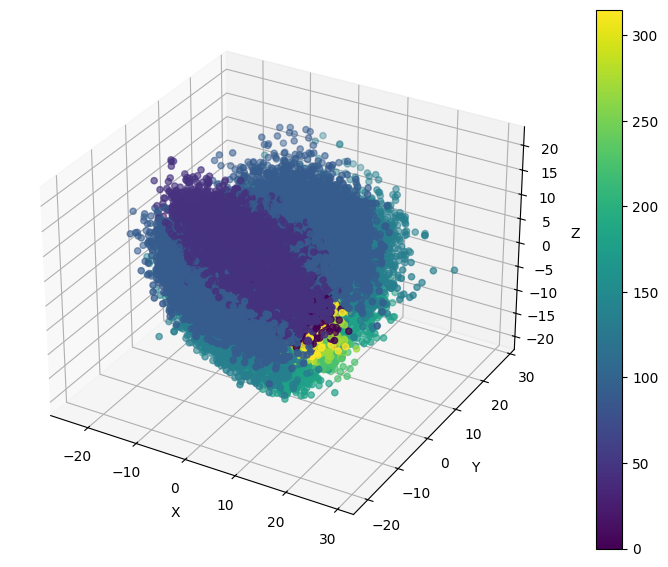

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent_space)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

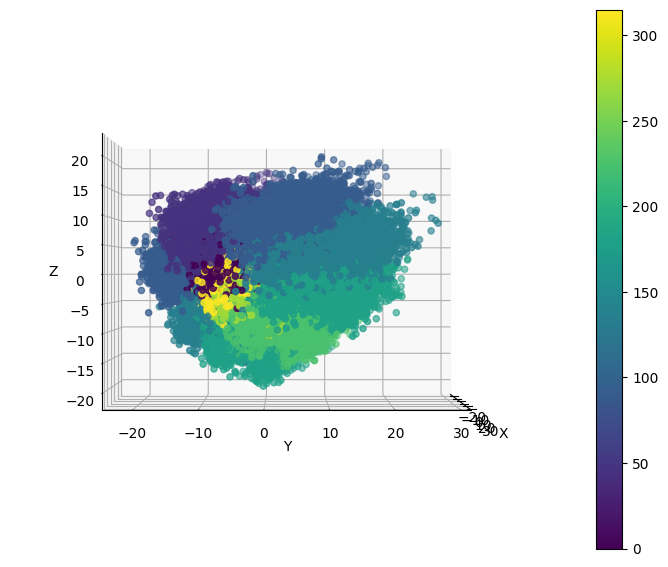

In [22]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent_space)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 0)
plt.show()

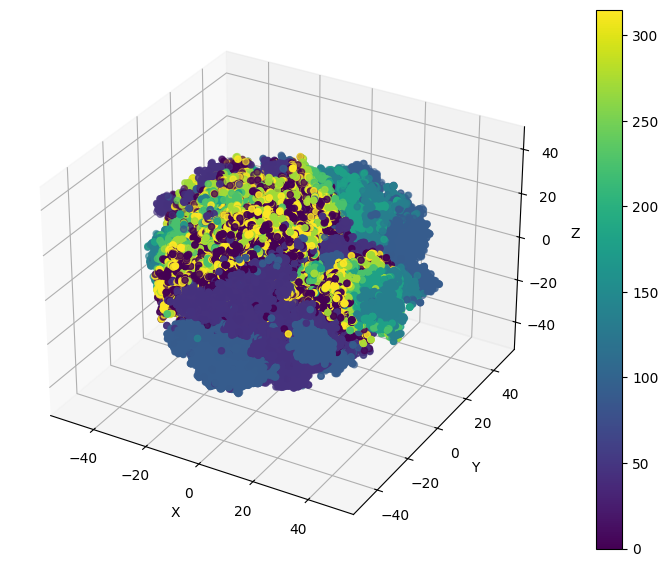

In [9]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

pca = TSNE(n_components=3)
X_pca = pca.fit_transform(latent_space)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

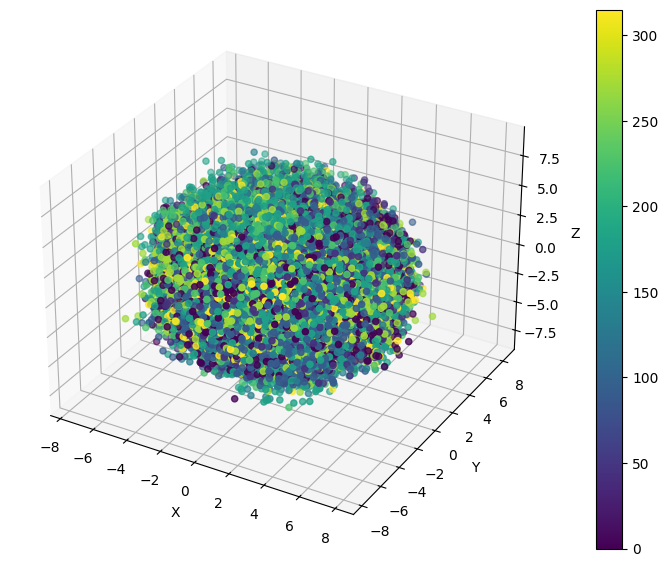

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]


pca = PCA(n_components=3)
X_pca = pca.fit_transform(data)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

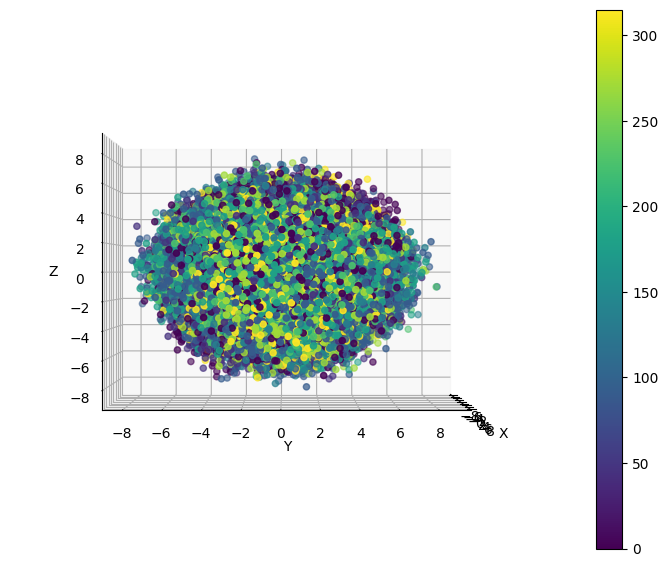

In [26]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(data)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 0)
plt.show()